## **Complementary Data-fusion based on CPKL**

[Multi-fidelity](https://github.com/cornellius-gp/gpytorch/issues/594)

#### **1. Import libraries**

In [1]:
from copy import deepcopy
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

torch.set_default_dtype(torch.float64)
plt.style.use(['dark_background', 'bmh'])
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
plt.rc('axes', facecolor='k')
plt.rc('figure', facecolor='k')
plt.rc('figure', figsize= (6, 3), dpi=150)

import warnings
warnings.filterwarnings('ignore')

#### **2. Get training data**

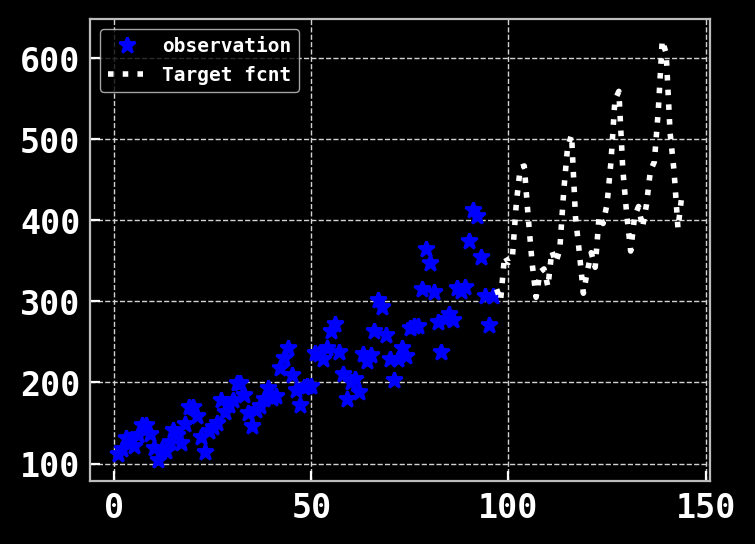

<class 'torch.Tensor'> torch.Size([96]) torch.float32
<class 'torch.Tensor'> torch.Size([96]) torch.float32
<class 'torch.Tensor'> torch.Size([48]) torch.float32
<class 'torch.Tensor'> torch.Size([48]) torch.float32
1


In [2]:
from test_fcnt import get_test_fcnt
from Util_CPKL import *
# 1. DGP_sin
# 2. DGP_cubic
# 3. DGP_complex_sin
# 4. DGP_non_stationary
# 5. Frank function in 2-dimensional space
# 6. airline. airline dataset
# 7. CO2 dataset
rand_seed0 = 1234
n_pts = 20
train_x, train_y, test_x, test_y = get_test_fcnt(
    6, n_pts = n_pts,
    seed = rand_seed0) # 'airline'

print(type(train_x), train_x.shape, train_x.dtype)
print(type(train_y), train_y.shape, train_y.dtype)
print(type(test_x), test_x.shape, test_x.dtype)
print(type(test_y), test_y.shape, test_y.dtype)

# get information trainint set for initializing hyper-parameters
traindata_info = initialize_hyperparameters(train_x, train_y)

#### **3. Define functions for CPKL**

In [3]:
from gpytorch.kernels import RBFKernel, LinearKernel, RQKernel, MaternKernel, CosineKernel, PeriodicKernel

# Set active dimensions
action_dims = torch.tensor([i for i in range(0, train_x.dim())])
# traindata_info['min_dist_x'], traindata_info['max_dist_y'], traindata_info['min_dist_y'], traindata_info['max_dist_y']

lengthscale_prior = gpytorch.priors.NormalPrior(traindata_info['med_dist_x'], traindata_info['max_dist_x'])
variance_prior = gpytorch.priors.NormalPrior(traindata_info['med_dist_y'], traindata_info['max_dist_y'] - traindata_info['min_dist_y'])
periodlength_prior = gpytorch.priors.NormalPrior(traindata_info['med_dist_x'], traindata_info['max_dist_x'] - traindata_info['min_dist_x'])

for i in range(0, train_x.dim()):
    if i == 0:
        lin_ken = LinearKernel(active_dims = i, variance_prior = variance_prior, variance_constraint = gpytorch.constraints.Interval(0.5*traindata_info['min_dist_y'], traindata_info['max_dist_y']*1.5))
        # Samller values of period_length means higher frequency in signals
        cos_ken = CosineKernel(active_dims = i, period_length_prior = periodlength_prior, period_length_constraint = gpytorch.constraints.Interval(0.5*traindata_info['min_dist_x'], traindata_info['max_dist_x']*1.5))
        cos_ken1 = CosineKernel(active_dims = i, period_length_prior = periodlength_prior, period_length_constraint = gpytorch.constraints.LessThan(0.5*traindata_info['min_dist_x']))

    else:
        lin_ken *= lin_ken
        cos_ken *= cos_ken
        cos_ken1 *= cos_ken1

# define the kernels
base_kernels = {
    'rbf': lambda: RBFKernel(active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior),
    'lin': lambda: lin_ken,
    'cos': lambda: cos_ken,
    'cos1': lambda: cos_ken1,
    # 'per': lambda: PeriodicKernel(active_dims = action_dims, ard_num_dims = len(action_dims), period_length_prior  = periodlength_prior, lengthscale_prior=lengthscale_prior),
    'rq': lambda: RQKernel(active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior),
    'mat12': lambda: MaternKernel(nu=0.5, active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior),
    'mat32': lambda: MaternKernel(nu=1.5, active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior),
    'mat52': lambda: MaternKernel(nu=2.5, active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior),
    # 'mat52': lambda: MaternKernel(nu=2.5, active_dims = action_dims, ard_num_dims = len(action_dims), lengthscale_prior=lengthscale_prior, lengthscale_constraint = gpytorch.constraints.Interval(0.1*traindata_info['min_dist_x'], traindata_info['max_dist_x']*2.0)),
}

# base_likelihood = lambda: gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
base_likelihood = lambda: gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-3))

# Assume: likelihood noise constraint was defined so that 1e-4 is within range.
likelihood0 = base_likelihood()
if 0:
    likelihood0.noise = 1e-4  # Some small value, but don't make it too small or numerical performance will suffer. I recommend 1e-4.
    likelihood0.noise_covar.raw_noise.requires_grad_(False)  # Mark that we don't want to train the noise.

#### **4. Run CPKL!**

random
[rbf] best bic: 83.1132
[lin] best bic: 133.2911
[cos] best bic: 142.8387
[cos1] best bic: 142.1576
[rq] best bic: 67.2256
[mat12] best bic: 75.4887
[mat32] best bic: 71.8560
[mat52] best bic: 75.6655


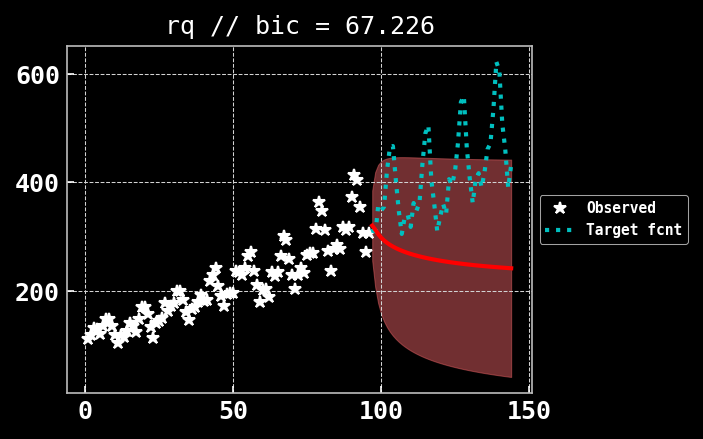

MAE : 152.35821533203125 // MSE : 30904.40625
%%%%%%%%%%%%%%%%%%%%%
[(rq+rbf)] best bic: 68.3890
[(rq+lin)] best bic: 66.1807
[(rq+cos)] best bic: 66.6660
[(rq+cos1)] best bic: 64.3973
[(rq+rq)] best bic: 72.9161
[(rq+mat12)] best bic: 70.9239
[(rq+mat32)] best bic: 69.0936
[(rq+mat52)] best bic: 68.7478
[(rq*rbf)] best bic: 68.2955
[(rq*lin)] best bic: 99.1938
[(rq*cos)] best bic: 66.9406
[(rq*cos1)] best bic: 67.0359
[(rq*rq)] best bic: 72.8895
[(rq*mat12)] best bic: 70.9441
[(rq*mat32)] best bic: 68.9379
[(rq*mat52)] best bic: 68.6271


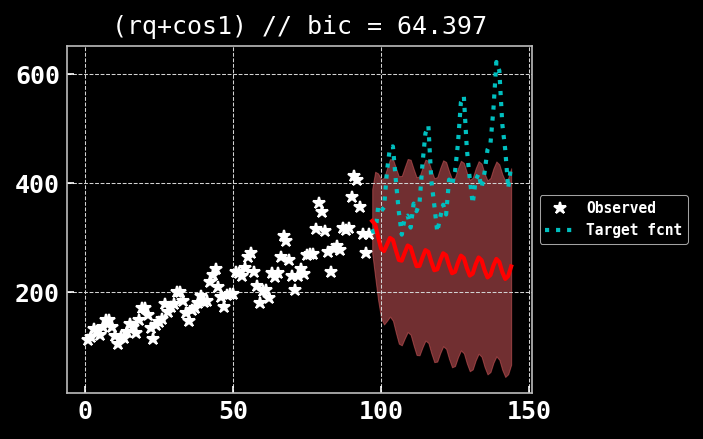

MAE : 154.63482666015625 // MSE : 30862.421875
%%%%%%%%%%%%%%%%%%%%%
[((rq+cos1)+rbf)] best bic: 61.1404
[((rq+cos1)+lin)] best bic: 61.5243
[((rq+cos1)+cos)] best bic: 52.6586
[((rq+cos1)+cos1)] best bic: 58.7109
[((rq+cos1)+rq)] best bic: 68.5763
[((rq+cos1)+mat12)] best bic: 62.8682
[((rq+cos1)+mat32)] best bic: 61.9942
[((rq+cos1)+mat52)] best bic: 64.5047
[((rq+cos1)*rbf)] best bic: 67.7921
[((rq+cos1)*lin)] best bic: 113.3032
[((rq+cos1)*cos)] best bic: 69.1901
[((rq+cos1)*cos1)] best bic: 67.6103
[((rq+cos1)*rq)] best bic: 72.4859
[((rq+cos1)*mat12)] best bic: 81.6673
[((rq+cos1)*mat32)] best bic: 69.9729
[((rq+cos1)*mat52)] best bic: 68.6466


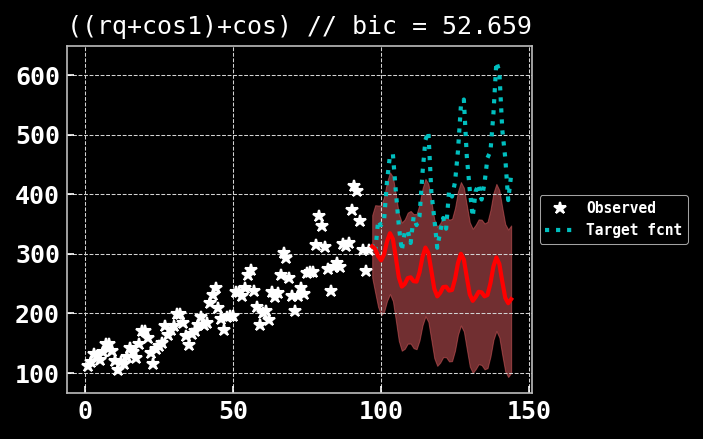

MAE : 149.19717407226562 // MSE : 27763.099609375
%%%%%%%%%%%%%%%%%%%%%
[(((rq+cos1)+cos)+rbf)] best bic: 38.0997
[(((rq+cos1)+cos)+lin)] best bic: 25.1959
[(((rq+cos1)+cos)+cos)] best bic: 32.7632
[(((rq+cos1)+cos)+cos1)] best bic: 32.7993
[(((rq+cos1)+cos)+rq)] best bic: 42.6710
[(((rq+cos1)+cos)+mat12)] best bic: 42.6421
[(((rq+cos1)+cos)+mat32)] best bic: 39.0948
[(((rq+cos1)+cos)+mat52)] best bic: 38.5183
[(((rq+cos1)+cos)*rbf)] best bic: 48.1434
[(((rq+cos1)+cos)*lin)] best bic: 122.8232
[(((rq+cos1)+cos)*cos)] best bic: 51.2825
[(((rq+cos1)+cos)*cos1)] best bic: 45.3077
[(((rq+cos1)+cos)*rq)] best bic: 52.7246
[(((rq+cos1)+cos)*mat12)] best bic: 66.9951
[(((rq+cos1)+cos)*mat32)] best bic: 52.9795
[(((rq+cos1)+cos)*mat52)] best bic: 50.6163


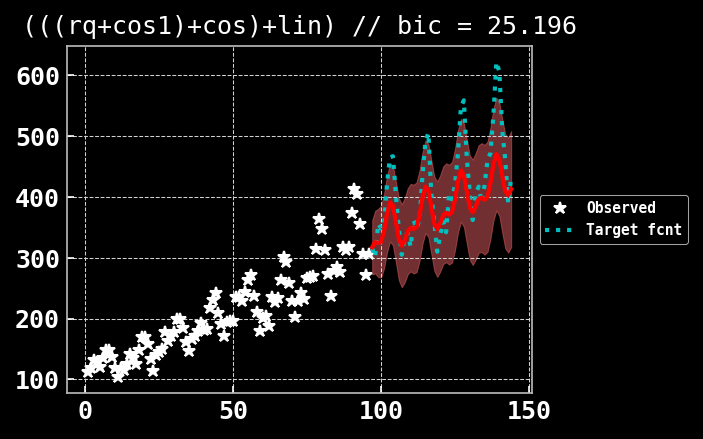

MAE : 40.17920684814453 // MSE : 2925.491455078125
%%%%%%%%%%%%%%%%%%%%%
[((((rq+cos1)+cos)+lin)+rbf)] best bic: 30.3846
[((((rq+cos1)+cos)+lin)+lin)] best bic: 29.6750
[((((rq+cos1)+cos)+lin)+cos)] best bic: 14.9061
[((((rq+cos1)+cos)+lin)+cos1)] best bic: 14.5336
[((((rq+cos1)+cos)+lin)+rq)] best bic: 31.5300
[((((rq+cos1)+cos)+lin)+mat12)] best bic: 27.7199
[((((rq+cos1)+cos)+lin)+mat32)] best bic: 27.5093
[((((rq+cos1)+cos)+lin)+mat52)] best bic: 30.5646
[((((rq+cos1)+cos)+lin)*rbf)] best bic: 10.3499
[((((rq+cos1)+cos)+lin)*lin)] best bic: 131.4117
[((((rq+cos1)+cos)+lin)*cos)] best bic: 54.7211
[((((rq+cos1)+cos)+lin)*cos1)] best bic: 13.6372
[((((rq+cos1)+cos)+lin)*rq)] best bic: 14.7867
[((((rq+cos1)+cos)+lin)*mat12)] best bic: 17.7026
[((((rq+cos1)+cos)+lin)*mat32)] best bic: 10.6917
[((((rq+cos1)+cos)+lin)*mat52)] best bic: 10.3644


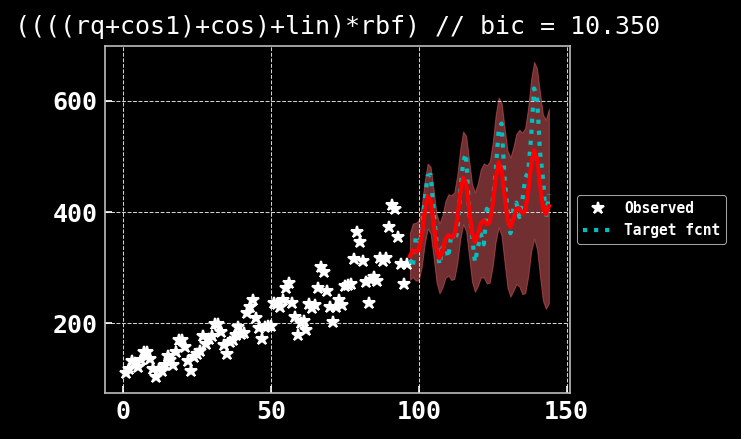

MAE : 28.880922317504883 // MSE : 1456.6312255859375
%%%%%%%%%%%%%%%%%%%%%
[(((((rq+cos1)+cos)+lin)*rbf)+rbf)] best bic: 15.5766
[(((((rq+cos1)+cos)+lin)*rbf)+lin)] best bic: 12.7733
[(((((rq+cos1)+cos)+lin)*rbf)+cos)] best bic: -2.3230
[(((((rq+cos1)+cos)+lin)*rbf)+cos1)] best bic: -2.3212
[(((((rq+cos1)+cos)+lin)*rbf)+rq)] best bic: 20.0842
[(((((rq+cos1)+cos)+lin)*rbf)+mat12)] best bic: 16.6976
[(((((rq+cos1)+cos)+lin)*rbf)+mat32)] best bic: 15.6174
[(((((rq+cos1)+cos)+lin)*rbf)+mat52)] best bic: 15.5752
[(((((rq+cos1)+cos)+lin)*rbf)*rbf)] best bic: 16.3089
[(((((rq+cos1)+cos)+lin)*rbf)*lin)] best bic: 110.1070
[(((((rq+cos1)+cos)+lin)*rbf)*cos)] best bic: 32.2966
[(((((rq+cos1)+cos)+lin)*rbf)*cos1)] best bic: 20.8760
[(((((rq+cos1)+cos)+lin)*rbf)*rq)] best bic: 20.1288
[(((((rq+cos1)+cos)+lin)*rbf)*mat12)] best bic: 23.4470
[(((((rq+cos1)+cos)+lin)*rbf)*mat32)] best bic: 16.8746
[(((((rq+cos1)+cos)+lin)*rbf)*mat52)] best bic: 16.6100


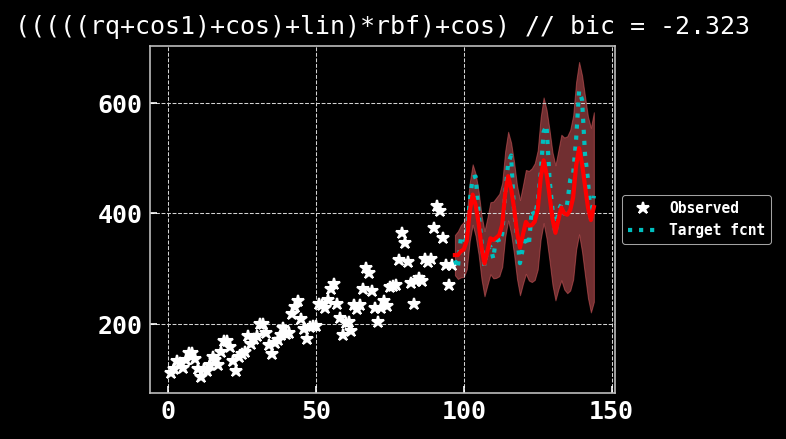

MAE : 27.197219848632812 // MSE : 1382.5086669921875
%%%%%%%%%%%%%%%%%%%%%
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+rbf)] best bic: 2.8299
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+lin)] best bic: 0.0839
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+cos)] best bic: 1.0194
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+cos1)] best bic: 1.0195
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+rq)] best bic: 7.3616
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+mat12)] best bic: 3.8626
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+mat32)] best bic: 2.9066
[((((((rq+cos1)+cos)+lin)*rbf)+cos)+mat52)] best bic: 2.8575
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*rbf)] best bic: 4.3193
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*lin)] best bic: 123.7165
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*cos)] best bic: 27.8574
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*cos1)] best bic: 10.5571
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*rq)] best bic: 6.8067
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*mat12)] best bic: 16.1712
[((((((rq+cos1)+cos)+lin)*rbf)+cos)*mat32)] best bic: 5.9723
[((((((rq+cos1)+cos)+lin)

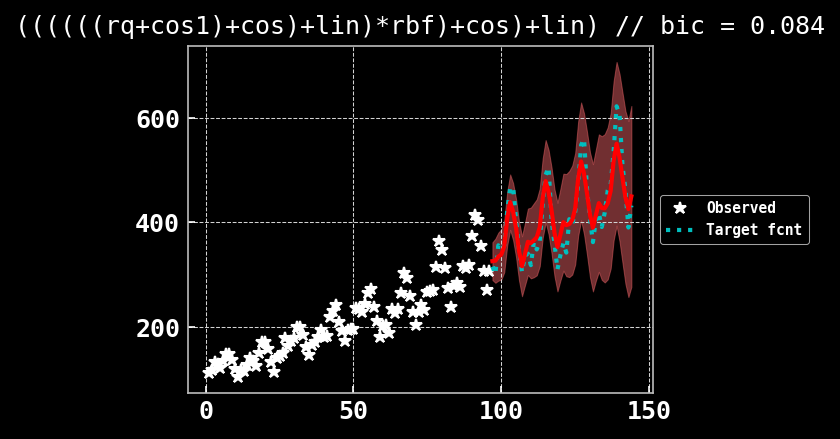

MAE : 23.675146102905273 // MSE : 898.0090942382812
%%%%%%%%%%%%%%%%%%%%%


In [4]:
import numpy as np
multi_restart_option = {}
multi_restart_option['sampling'] = 'lhs'
multi_restart_option['traindata_info'] = traindata_info
multi_restart_option['n_eval'] = 20

multi_restart_option['sampling'] = 'random'
multi_restart_option['n_eval'] = 20
multi_restart_option['traindata_info'] = traindata_info

best_model, best_models, best_metrics = RUN_CPKL(train_x, train_y, likelihood0, base_kernels,
                                test_x = test_x, test_y = test_y, multi_restart_option = multi_restart_option,
                                fix_value_learned = True, max_depth = 15, 
                                training_iter = 100, standardize = True, tolerance = 1e-4)

In [5]:
for model in best_models:
    for param_name, param in model.named_parameters():
        print(f'Parameter name: {param_name:42} value = {param}')
    print('%%%%%%%%%%%%%' * 5)

Parameter name: likelihood.noise_covar.raw_noise           value = Parameter containing:
tensor([-9.8996], dtype=torch.float32, requires_grad=True)
Parameter name: mean_module.raw_constant                   value = 0.04049075394868851
Parameter name: base_kernel.raw_lengthscale                value = Parameter containing:
tensor([-2.1064], dtype=torch.float32, requires_grad=True)
Parameter name: base_kernel.raw_alpha                      value = Parameter containing:
tensor([-2.3502], dtype=torch.float32, requires_grad=True)
Parameter name: covar_module.raw_outputscale               value = 1.0927602052688599
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Parameter name: likelihood.noise_covar.raw_noise           value = Parameter containing:
tensor([-11.0666], dtype=torch.float32, requires_grad=True)
Parameter name: mean_module.raw_constant                   value = 0.008441116660833359
Parameter name: base_kernel.kernels.0.raw_lengthscale      value = Parameter con

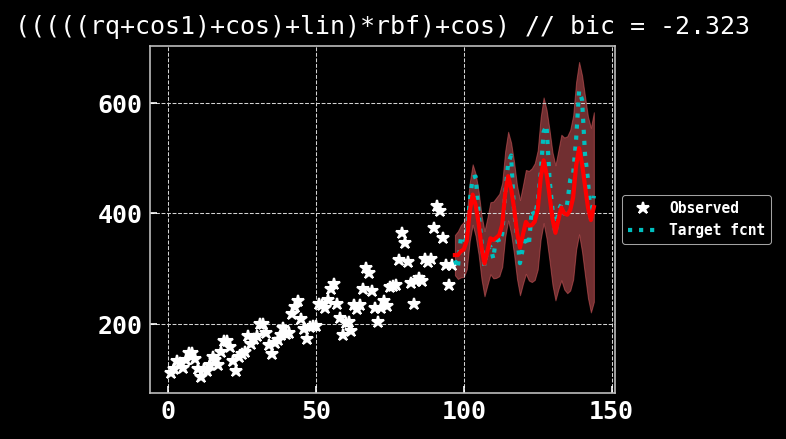

MAE : 27.197219848632812 // MSE : 1382.5086669921875
%%%%%%%%%%%%%%%%%%%%%


(27.19722, 1382.5087)

In [6]:
# Plot result
plot_result(best_model, test_x, test_y)

[1D Multi-fidelity models in GPyTorch](https://github.com/cornellius-gp/gpytorch/issues/594)  
[2D Multi-fidelity models in GPyTorch](https://github.com/cornellius-gp/gpytorch/issues/1651)